**Zipper: Data exploration and preprocessing**
---
Companion notebooks from the medium article [Deep Zip: an open zipper detector](https://medium.com/@jfrederic.plante/deep-zip-83eb78f9963e).

The following part on training can be found [here](https://www.kaggle.com/blocks/zipper-training/)

You can also find the capture app for iOS at https://github.com/jeanfredericplante/lowflyer

---

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import fastai
import math
import datetime
import matplotlib.pyplot as plt
import os
import lightgbm as lgb
from tqdm import tqdm, tqdm_notebook

 # Data exploration and preparation

In [2]:
CSV_PATH = "../input/zipper4/zipper4"
all_csvs = os.listdir(CSV_PATH)
len(all_csvs)

61

In [3]:
def add_ma_aa_norm(df):
    df["ma"] = df.apply(lambda x: np.linalg.norm([x.mx,x.my,x.mz]),axis=1 )
    df["aa"] = df.apply(lambda x: np.linalg.norm([x.ax,x.ay,x.az]),axis=1 )
    return df
   

In [4]:
def process_csv(f="", keep_raw = False, apply_high_pass = True, offset_start = 100, offset_end=300):
    # offset is the number of samples to clip from each end of the sample
    if len(f) == 0:
        print("needs filename"); return
    else:
        df_tmp = pd.read_csv(CSV_PATH+"/"+ f)
        df_tmp["episode"] = i
        def add_column_from_name(df, filename, key="open"):
            df[key] = 0
            if key in filename: df[key] = 1
            return df
        df_tmp = add_column_from_name(df_tmp, all_csvs[i], "open")
        dfdf_tmp_test = add_column_from_name(df_tmp, all_csvs[i], "walking")
        df_tmp.sort_values("tm", inplace=True)
        df_tmp.drop(columns=['ma','aa','ta','tm'], inplace=True)
        if apply_high_pass is True:
            for c in ['mx','my','mz','ax','ay','az']:
                df_tmp[c] = high_pass(df_tmp[c])
        df_tmp = add_ma_aa_norm(df_tmp)
        if keep_raw is False:
            df_tmp.drop(columns=['mx','my','mz','ax','ay','az'], inplace=True)
        df_tmp = df_tmp[offset_start:-offset_end]
        time_idx = pd.date_range(start = datetime.datetime(2019, 1, 1), periods = df_tmp.index.size, freq='30ms')
        df_tmp = df_tmp.set_index(time_idx)
        return df_tmp


## Aggregating all measures into one dataframe

In [5]:
df_all = pd.DataFrame()
long_start_cut_list = [9,11,58,15,48,52,49]
avg_end_cut_list = [2,5,7,8,10,11,12,13,18,19,21,25,28,31,37,49,51,53,54,56,57,59,60]
long_endcut_list = [0,4,15,24,30,32,33,35,39, 41, 42, 44, 46,47, 48,  56,57]
very_long_endcut_list = [3,22,52,28,55,50]
for i,f in enumerate(all_csvs):
    offset_start = 100
    if i in long_start_cut_list:
        offset_start = 200
    if i in very_long_endcut_list:
        offset_end = 400
    elif i in long_endcut_list:
        offset_end = 350
    elif i in avg_end_cut_list:
        offset_end = 250
    else:
        offset_end = 120
    df_tmp = process_csv(f, keep_raw=True, apply_high_pass=False, offset_start=offset_start, offset_end=offset_end)

    df_tmp["episode"] = i
    df_all = df_all.append(df_tmp)

How balanced is our dataset?

In [6]:
size_per_episode = df_all.groupby("episode").open.count()
size_per_episode = size_per_episode.to_frame()
size_per_episode = size_per_episode.rename({"open":"length"}, axis="columns")
size_per_episode["open"] = df_all.groupby("episode").open.mean().values
size_per_episode["walking"] = df_all.groupby("episode").walking.mean().values
size_per_episode.reset_index().set_index(["open","episode"]).pivot(columns="walking").groupby("open").sum()

length         
walking        0        1
open                     
0        11829.0  24990.0
1         9637.0  38763.0

In [7]:
print(f'total episodes {len(size_per_episode)}, total samples {size_per_episode.length.sum()}')

total episodes 60, total samples 85219


In [8]:
df_all.to_pickle('df_all.pkl')
size_per_episode.to_pickle('size_per_episode.pkl')

## Sanity checks histogram of the observations

In [9]:
# Quick check to see if the time series clipping is appropriate and samples look ok

In [10]:
all_episodes = df_all.episode.unique()
sanity_check = True

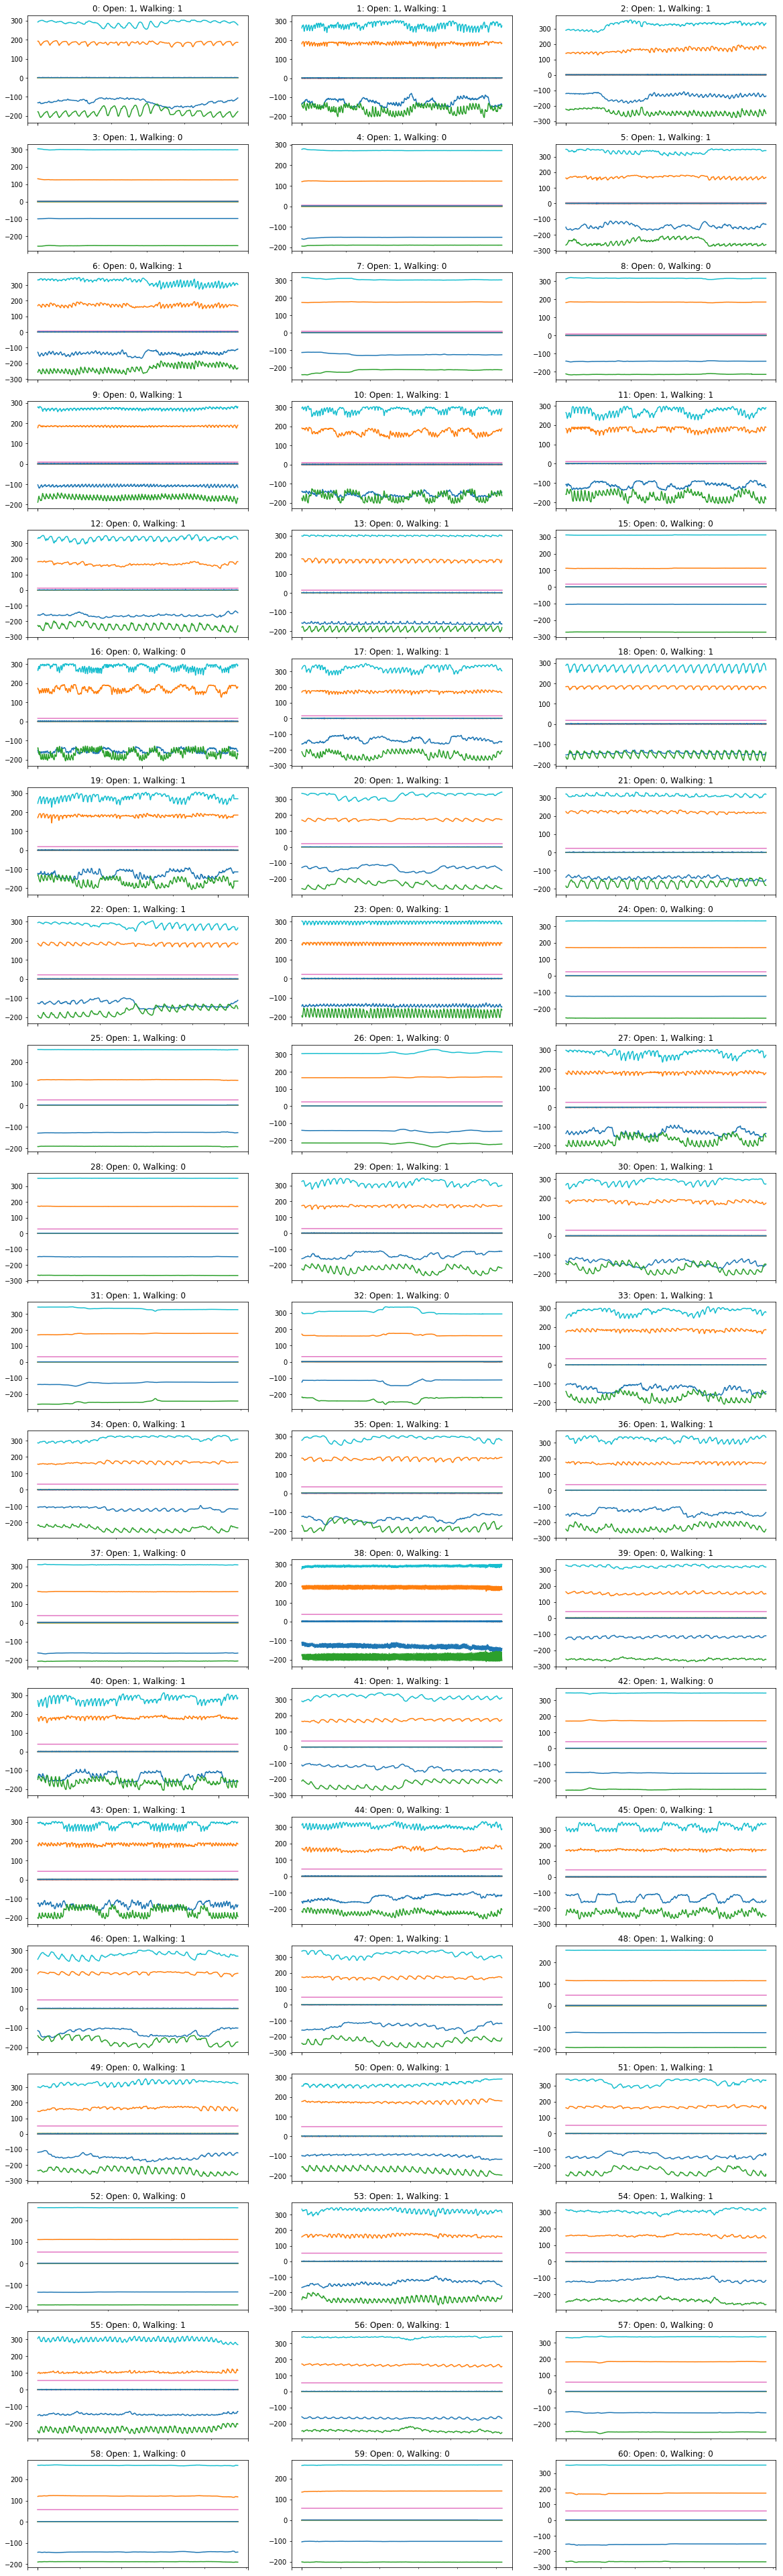

In [11]:
if sanity_check:
#     fig, axes = plt.subplots(all_episodes.size,6,figsize=(24,15))
#     for i,b in enumerate(all_episodes):
#         df_all[df_all.episode == b][["mx","my","mz","ax","ay","az"]].hist(ax=axes[i])
    ncol = 3; nrow = math.ceil(all_episodes.size/ncol)
    fig, axes = plt.subplots(nrow,ncol,figsize=(20,70))
    for i,b in enumerate(all_episodes):
        current_ax = axes[math.floor(i/ncol),i%ncol]
        current_df = df_all[df_all.episode == b]
        current_df.plot(ax=current_ax,legend=False)
        current_ax.set_title(f'{b}: Open: {current_df.open[0]}, Walking: {current_df.walking[0]}')
        current_ax.tick_params(axis='x', which='both',labelbottom=False)

Looks like episode 16 shouldn't be "non walking", we need to remove it

In [12]:
print(f'previous df all shape {df_all.shape}')
size_per_episode.drop(16, axis=0, inplace=True)
df_all = df_all[df_all.episode != 16]
print(f'new df all shape {df_all.shape}')


previous df all shape (85219, 11)
new df all shape (81383, 11)


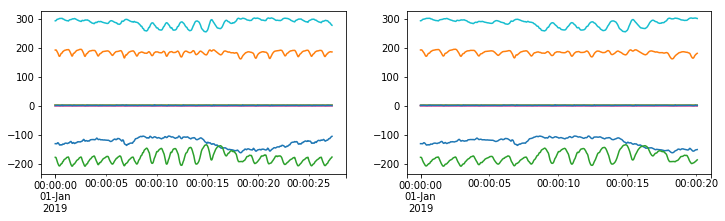

In [13]:
b=0
fig, ax = plt.subplots(1,2, figsize = (12,3))
df_all[df_all.episode == b].plot(ax=ax[0], legend=False)
df_all[df_all.episode == b].iloc[:-240].plot(ax=ax[1], legend=False)

### Example in each quadrant

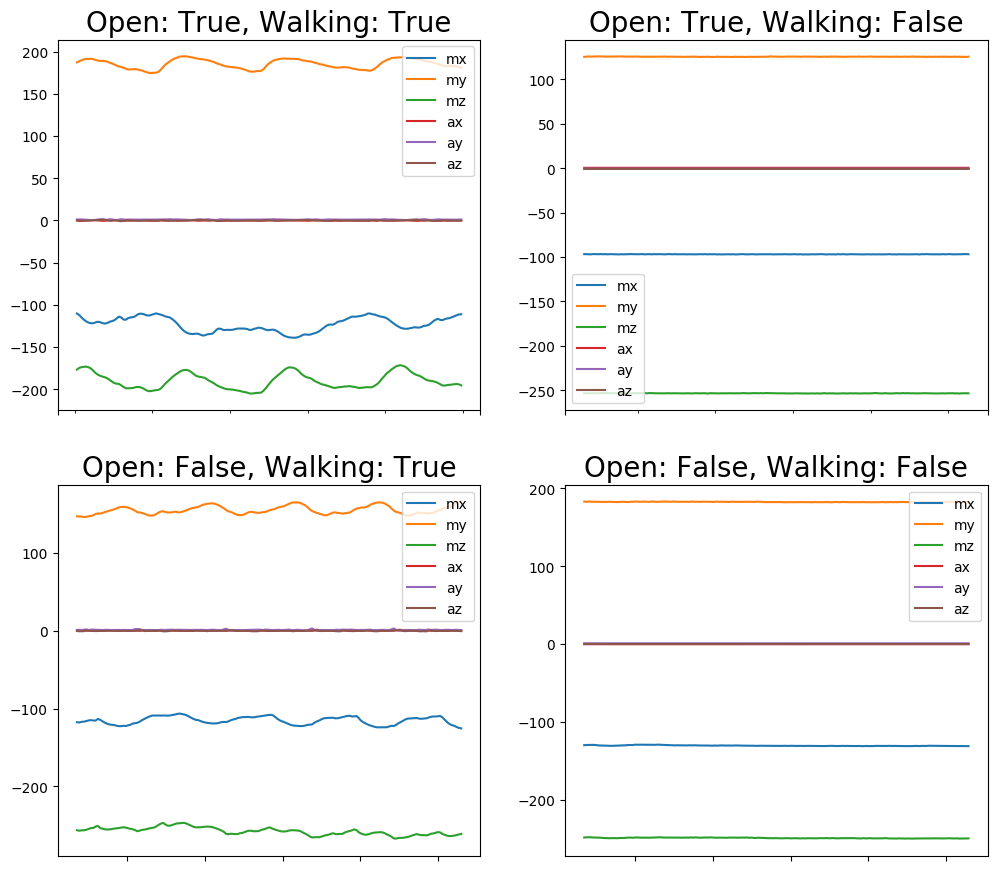

In [14]:
plt.style.use('default')
bquad = []
bquad.append(size_per_episode[(size_per_episode.open == 1) & (size_per_episode.walking == 1)].sample(1).index.values[0])
bquad.append(size_per_episode[(size_per_episode.open == 1) & (size_per_episode.walking == 0)].sample(1).index.values[0])
bquad.append(size_per_episode[(size_per_episode.open == 0) & (size_per_episode.walking == 1)].sample(1).index.values[0])
bquad.append(size_per_episode[(size_per_episode.open == 0) & (size_per_episode.walking == 0)].sample(1).index.values[0])

nrow = 2; ncol = 2; nsec = int(5/0.03)
fig, axes = plt.subplots(nrow,ncol,figsize=(12,12))
for i,b in enumerate(bquad):
    current_ax = axes[math.floor(i/ncol),i%ncol]
    current_df = df_all[df_all.episode == b]
    idxstart = int((len(current_df)-nsec)/2)
    current_df.iloc[idxstart:idxstart+nsec][["mx","my","mz","ax","ay","az"]].plot(ax=current_ax,legend=True)
    current_ax.set_title(f'Open: {current_df.open[0]==1}, Walking: {current_df.walking[0]==1}',fontsize=20)
    current_ax.tick_params(axis='x', which='both',labelbottom=False)



 ## Data normalization

One approach to normalizing to 0 is a high pass filter, but that doesn't address the amplitude. The other is looking at our train average per classifier and normalizing by average and norm. 

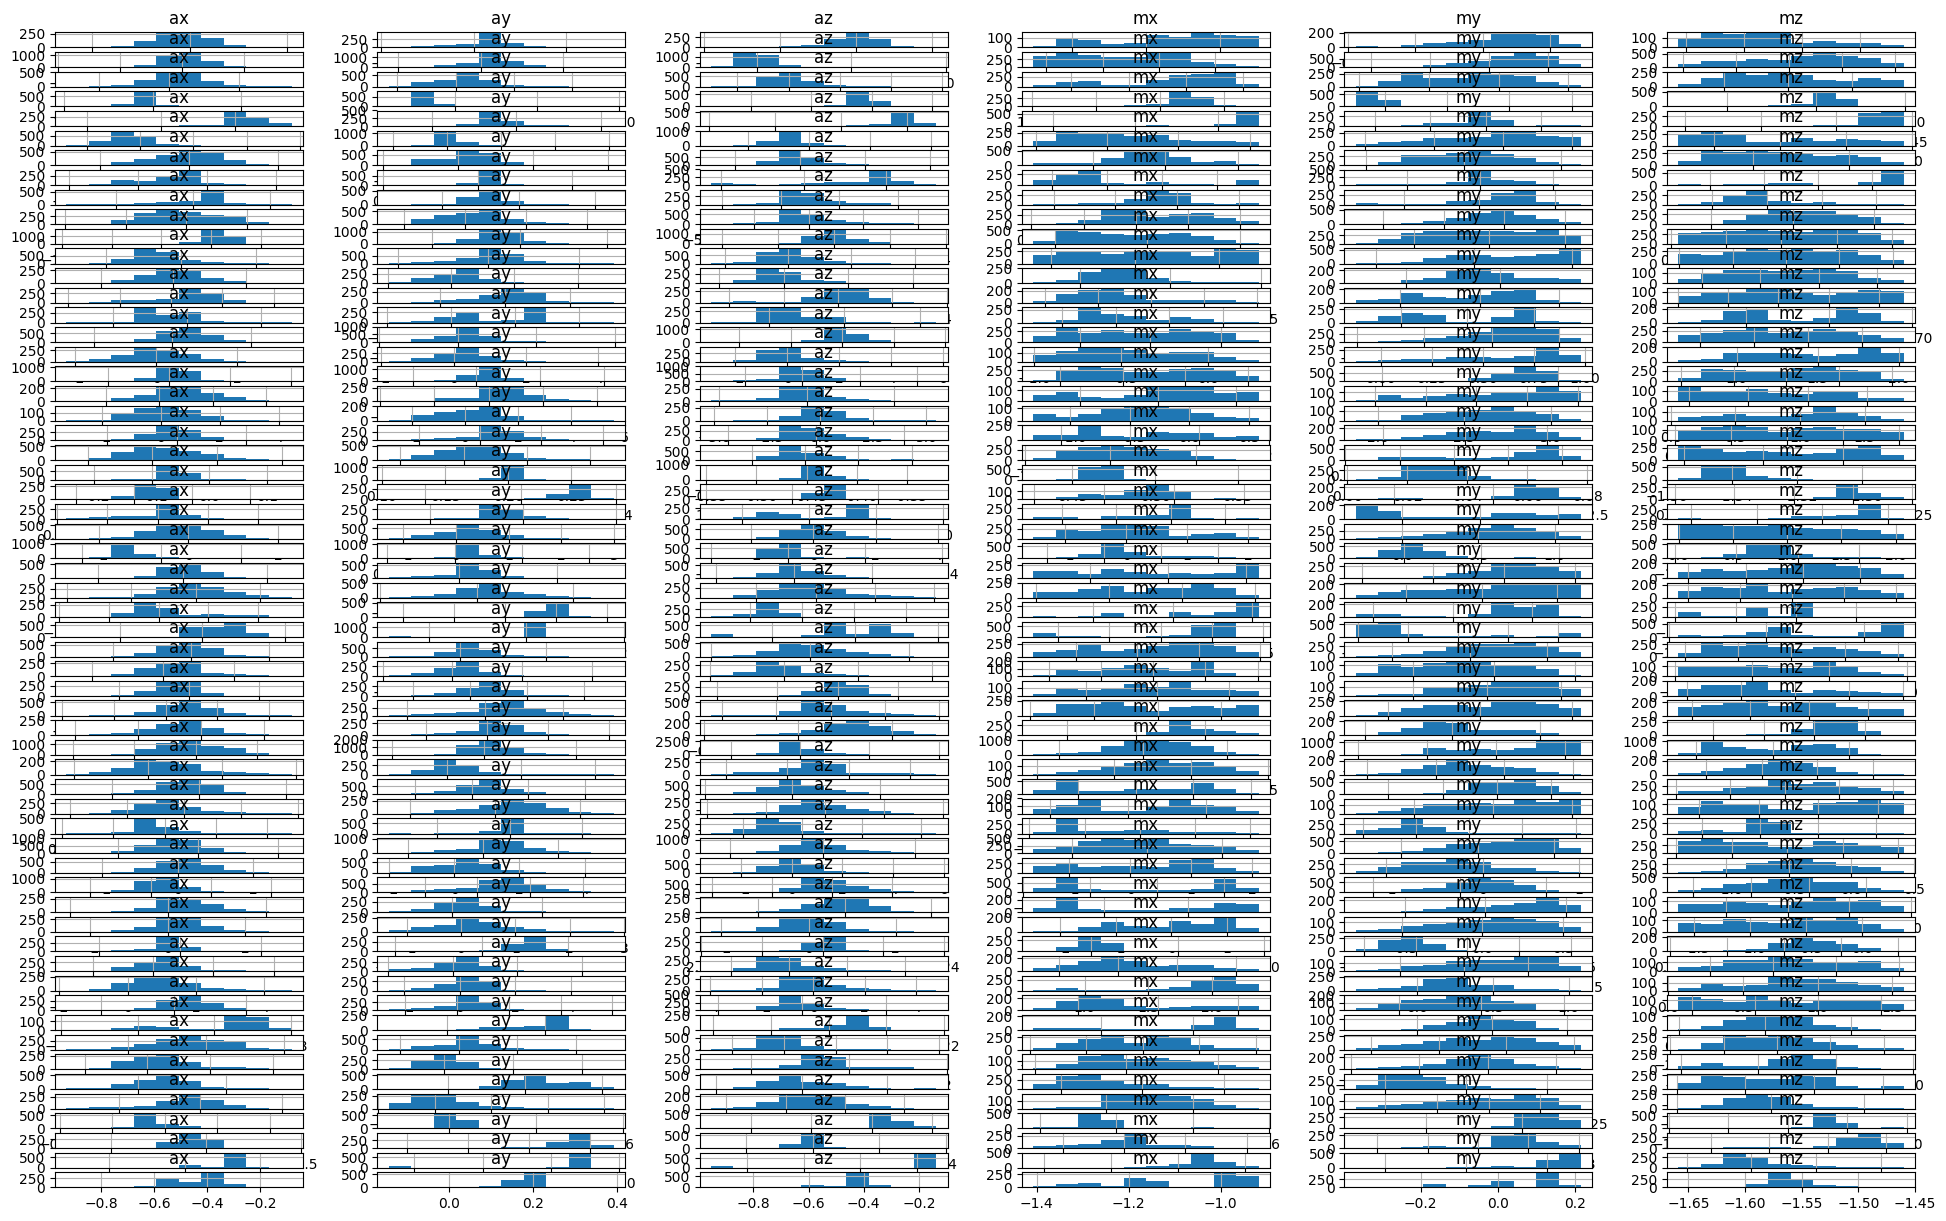

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_scale = ["mx","my","mz","ax","ay","az"]
scaler.fit(df_all[columns_to_scale])
scaler.mean_, scaler.scale_
df_all[columns_to_scale] = scaler.transform(df_all[columns_to_scale])
if sanity_check:
    all_episodes = df_all.episode.unique()
    fig, axes = plt.subplots(all_episodes.size,6,figsize=(24,15))
    for i,b in enumerate(all_episodes):
        df_all[df_all.episode == b][["mx","my","mz","ax","ay","az"]].hist(ax=axes[i])
df_all = add_ma_aa_norm(df_all)

In [16]:
df_all.to_pickle('df_all_norm.pkl')

## Plotting many examples in each quadrant to eyeball the signal

In [17]:
df_all = pd.read_pickle('df_all_norm.pkl')
nsamples = 60
nepisode = 5

### Walking: open vs close

In [18]:
plot_episodes = np.append(size_per_episode[(size_per_episode.walking == 1) & (size_per_episode.open == 1)].sample(nepisode).index.values, \
                         size_per_episode[(size_per_episode.walking == 1) & (size_per_episode.open == 0)].sample(nepisode).index.values)

In [19]:
def plot_section(episode, label = "ma", ax=[]):
    if ax == []:
        fig,ax = plt.subplots(1,1)
    df_tmp = df_all[df_all.episode == episode]
    ftitle = f"episode: {episode}, Walking: {df_tmp.walking[0]==1}, Open: {df_tmp.open[0]==1}"
    idx = np.random.randint(len(df_tmp)-nsamples)
    df_tmp = df_tmp[label].iloc[idx:idx+nsamples]
    df_tmp.plot(ax=ax); 
    ax.set_title(ftitle)

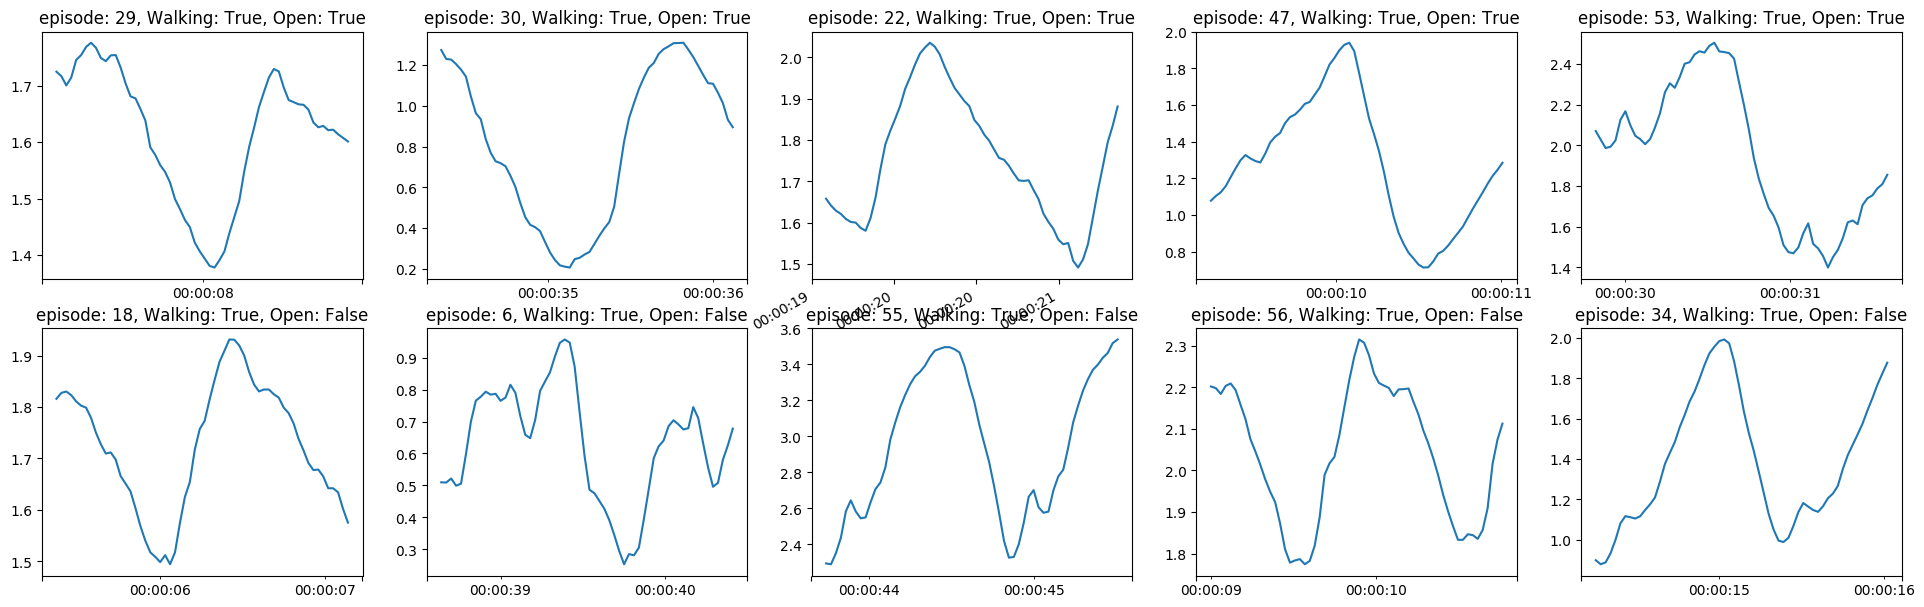

In [20]:
fig, axes = plt.subplots(2,nepisode, figsize=(24,8))
for i, n in enumerate(plot_episodes):
    plot_section(n, ax = axes[i // nepisode][i % nepisode])

Nothing really jumps as a difference here, maybe the signal is a bit more squigly when closed

### Walking vs non walking

In [21]:
plot_episodes = np.append(size_per_episode[(size_per_episode.walking == 0) ].sample(nepisode).index.values, \
                         size_per_episode[(size_per_episode.walking == 1) ].sample(nepisode).index.values)

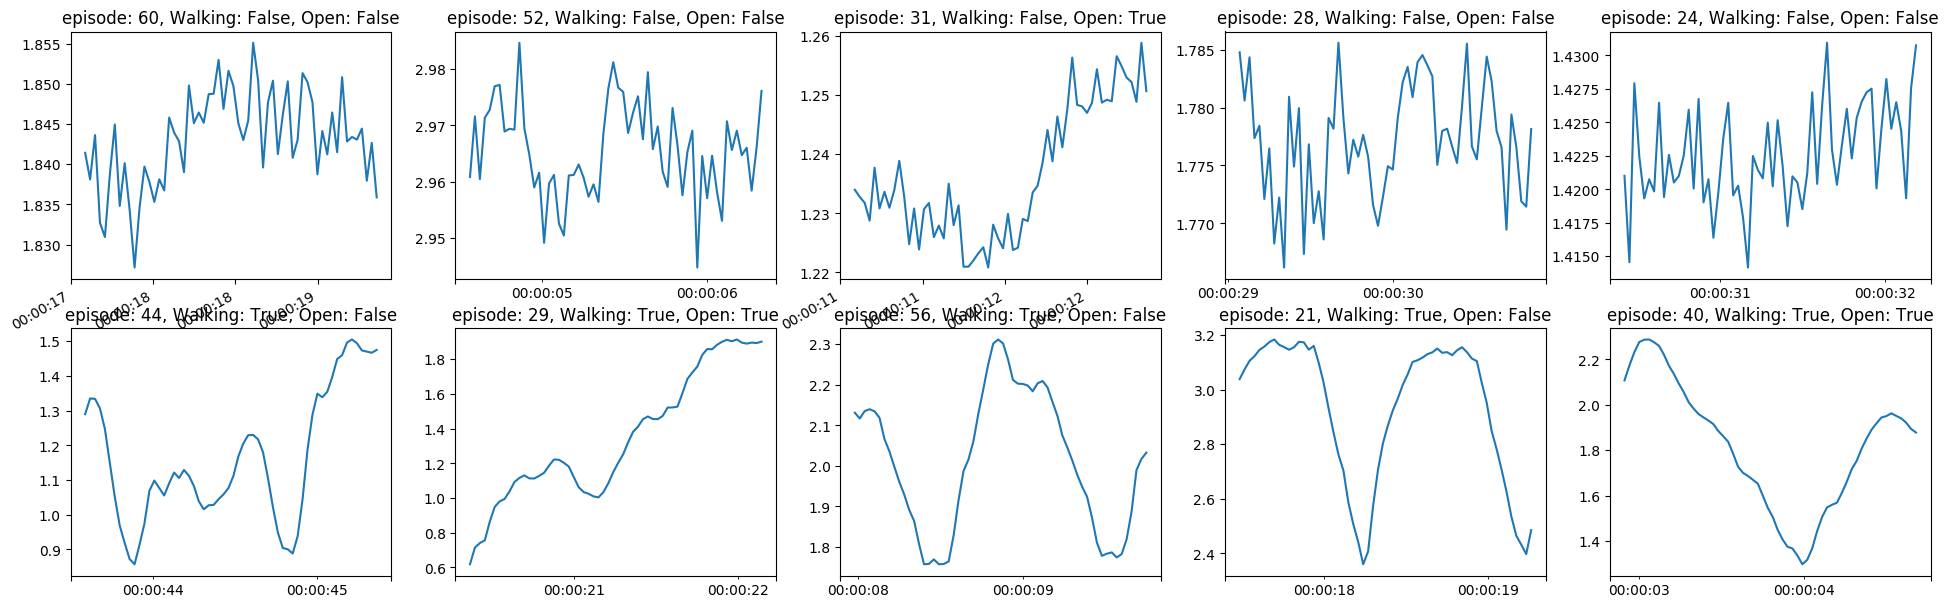

In [22]:
fig, axes = plt.subplots(2,nepisode, figsize=(24,8))
for i, n in enumerate(plot_episodes):
    plot_section(n, ax = axes[i // nepisode][i % nepisode])

here we see the amplitude is a clear distinction between walking and standing.